In [1]:
from fik import *

from os import path
import numpy as np
import pandas as pd
import sys
from matplotlib import pyplot as plt

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
logs_dir = 'FLIGHT'

gm_logs, cf_logs, ff_logs = [
    DATALOG.split_runs(path.join(logs_dir, devid, 'DATALOG.TXT'))
    for devid in ['GM', 'CF', 'FF']
]

print(gm_logs, cf_logs, ff_logs)


[<fik.DATALOG object at 0x7f19f72a6828>] [<fik.DATALOG object at 0x7f19f6722b38>] [<fik.DATALOG object at 0x7f19f6712828>]


No fix for run of 11740 lines at $AIRDOS,FF,96051b4,1290c00806a200920856a000a00000c9


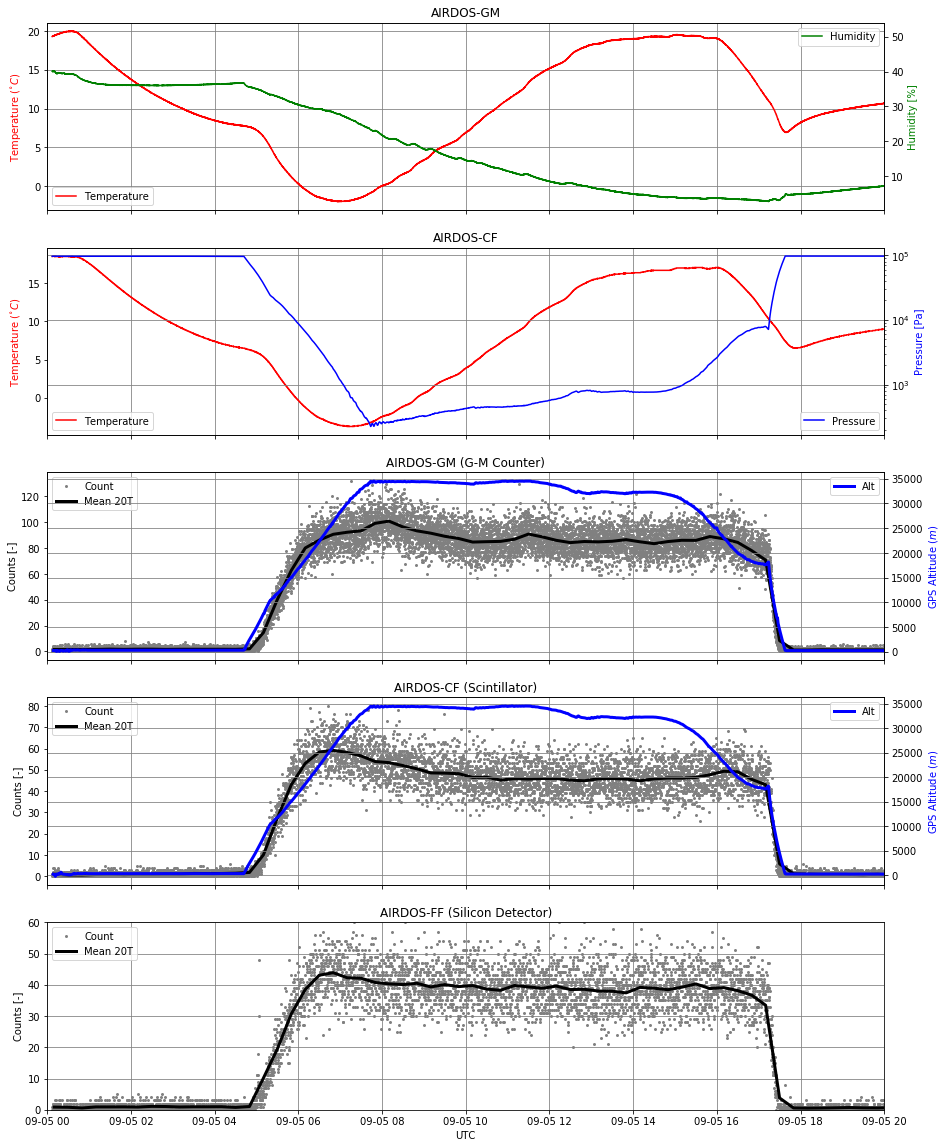

In [3]:
fig, (ax1, ax3, ax2, ax4, ax5) = plt.subplots(figsize=(15, 20), nrows=5, sharex=True)
ax1_twin = ax1.twinx()
ax2_twin = ax2.twinx()
ax3_twin = ax3.twinx()
ax4_twin = ax4.twinx()

MINUTES = 20
WINDOW = str(MINUTES) + 'T'
OFFSET = str(MINUTES/2) + 'T'

for dl in gm_logs:
    if 'gm' not in dl.__dict__ or not isinstance(dl.gm.index, pd.DatetimeIndex):
            sys.stderr.write("Skipping %d GM entries from %s" % (len(dl.gm), dl.greeting))
            continue

    ax2.set_title("AIRDOS-GM (G-M Counter)")
    ax2.set_ylabel('Counts [-]')
    ax2.plot(dl.gm.index, dl.gm['GMCount'], linestyle='', label='Count', marker='.', markeredgewidth=0, color='gray')
    ax2.plot(dl.gm['GMCount'].resample(WINDOW, loffset=OFFSET).mean(), label='Mean '+WINDOW, lw=3, color='black')
    ax2.grid(b=True, which='major', color='grey', linestyle='-', axis='x')
    ax2.legend(loc=2)
    ax1.set_ylabel('Temperature ($^{\circ}C$)', color='red')
    ax1.set_title("AIRDOS-GM")
    ax1.plot(dl.gm.index, dl.gm['Temp'], color='red', label='Temperature')
    ax1.set_xlim('2019-09-05 00:00','2019-09-05 20:00')
    ax1.grid(b=True, which='major', color='grey', linestyle='-')
    ax1.legend(loc=3)
    ax1_twin.set_ylabel('Humidity [%]', color='green')
    ax1_twin.plot(dl.gm.index, dl.gm['Humid'], label='Humidity', color='green')
    ax1_twin.legend()

    ax2_twin.set_ylabel('GPS Altitude ($m$)', color='blue')
    ax2_twin.plot(dl.nav.index, dl.nav['Alt'], color='blue', lw=3)
    ax2_twin.grid(b=True, which='major', color='grey', linestyle='-', axis='y')
    ax2_twin.legend(loc=1)

for dl in cf_logs:
    if 'candy' not in dl.__dict__ or not isinstance(dl.candy.index, pd.DatetimeIndex):
        sys.stderr.write("Skipping %d CANDY entries from %s" % (len(dl.candy), dl.greeting))
        continue
    
    spec = np.array(list(map(list, dl.candy['Bins'])))
    flux_series = pd.Series(np.sum(spec[:,30:], axis=1), index=dl.candy.index)
    
    ax4.set_title("AIRDOS-CF (Scintillator)")
    ax4.set_ylabel('Counts [-]')
    ax4.plot(flux_series.index, flux_series.values, linestyle='', label='Count', marker='.', markeredgewidth=0, color='gray')
    ax4.plot(flux_series.resample(WINDOW, loffset=OFFSET).mean(), label='Mean '+WINDOW, lw=3, color='black')
    ax4.grid(b=True, which='major', color='grey', linestyle='-', axis='x')
    ax4.legend(loc=2)
    ax3.set_title("AIRDOS-CF")
    ax3.set_ylabel('Temperature ($^{\circ}C$)', color='red')
    ax3.plot(dl.candy.index, dl.candy['Temp'], label='Temperature', color='red')
    ax3.grid(b=True, which='major', color='grey', linestyle='-', axis='x')
    ax3.legend(loc=3)
    #ax3_twin.set_ylim(0,2000)
    ax3_twin.set_yscale('log')
    ax3_twin.set_ylabel('Pressure [Pa]', color='blue')
    ax3_twin.plot(dl.candy.index, dl.candy['Pressure'], label='Pressure', color='blue')
    ax3_twin.grid(b=True, which='major', color='grey', linestyle='-')
    ax3_twin.legend(loc=4)
    
    ax4_twin.set_ylabel('GPS Altitude ($m$)', color='blue')
    ax4_twin.plot(dl.nav.index, dl.nav['Alt'], color='blue', lw=3)
    ax4_twin.grid(b=True, which='major', color='grey', linestyle='-')
    ax4_twin.legend(loc=1)

for dl, dl_cf in zip(ff_logs, cf_logs):
    if dl_cf.start_ts is None:
        sys.stderr.write("Skipping FF candy flux plot -- counterpart CF is without fix")
        continue
    
    dl.candy.index = dl_cf.start_ts + pd.to_timedelta(dl.candy['Time'], unit='sec')
    
    ax5.set_ylim(0, 60)
    ax5.set_title('AIRDOS-FF (Silicon Detector)')
    ax5.set_ylabel('Counts [-]')
    ax5.plot(dl.candy['Flux'], linestyle='', marker='.', label='Count', markeredgewidth=0, color='gray')
    ax5.plot(dl.candy['Flux'].resample(WINDOW, loffset=OFFSET).mean(), lw=3, label='Mean '+WINDOW, color='black')
    ax5.set_xlabel('UTC')
    ax5.grid(b=True, which='major', color='grey', linestyle='-')
    ax5.legend(loc=2)


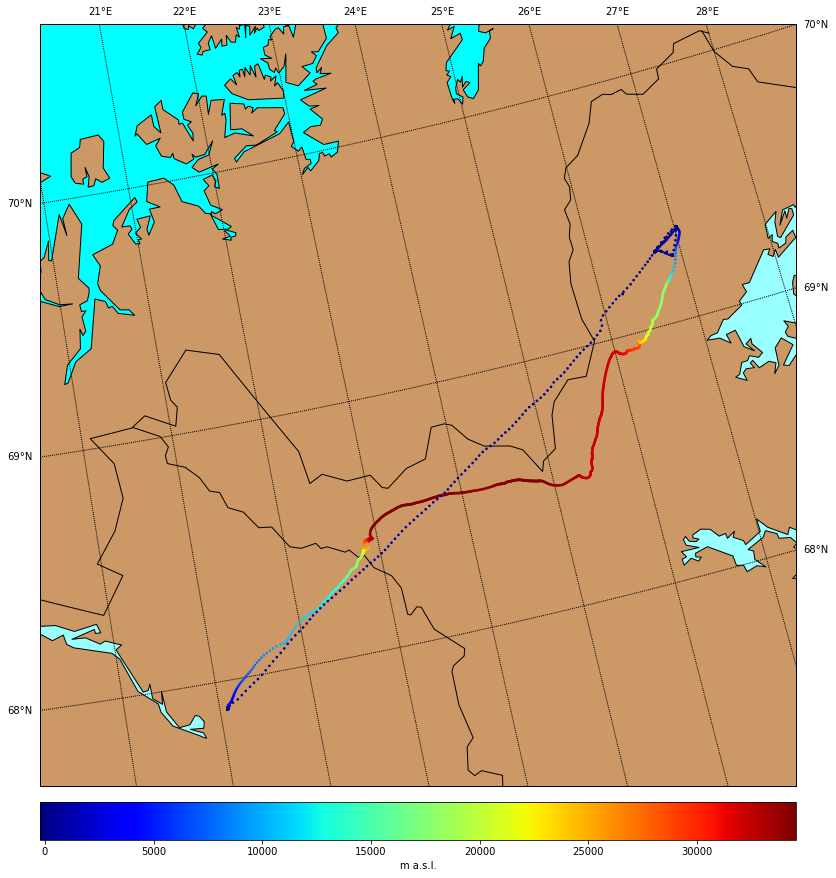

In [16]:
import time, calendar, datetime, numpy
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import urllib, os
import numpy as np

plt.figure(figsize=(15,15))
m = Basemap(llcrnrlon=19.0,llcrnrlat=67.7,urcrnrlon=29.0,urcrnrlat=70.0, epsg = 31284,resolution='i',projection='merc')

nav = cf_logs[0].nav.dropna()

x, y = m(list(nav["Lon"].array),list(nav["Lat"].array))
m.fillcontinents(color='#cc9966',lake_color='#99ffff')
#m.shadedrelief(scale=1)
m.drawcountries(linewidth=1)
m.drawcoastlines()
m.drawmapboundary(fill_color='aqua')

m.drawparallels(np.arange(67.,80.,),labels=[1,1,0,0])
m.drawmeridians(np.arange(19.,30.,),labels=[0,0,1,0])

im1 = m.scatter(x,y,c=list(nav["Alt"]), s=7, marker='o', linewidth=0, cmap='jet', zorder=99)
cb = m.colorbar(im1,"bottom", size="5%", pad="2%")
cb.set_label('m a.s.l.')
plt.show()

/srv/envdeploy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


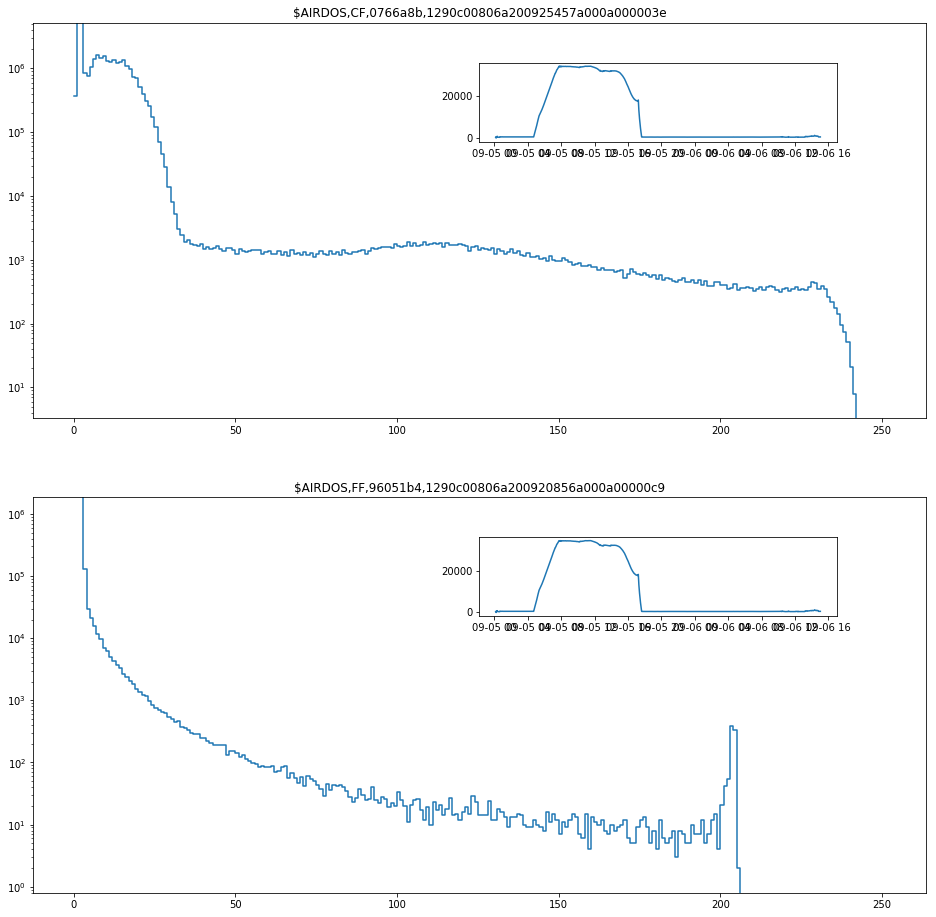

In [11]:
def plot_spectra_in_time(tfrom, tto):
    if isinstance(tto, pd.Timedelta):
        tto = tfrom + tto
    
    fig, axes = plt.subplots(figsize=(16, 16), nrows=2)
    
    for ax in axes.flat:
        nav_merged = pd.concat([log.nav for log in cf_logs])
        n = nav_merged[np.logical_and(nav_merged.index > tfrom, nav_merged.index < tto)]
        ax.inset_axes([0.5, 0.7, 0.4, 0.2]).plot(n.index, n['Alt'])
    
    for logs, axes in zip([cf_logs, ff_logs], axes):
        candy_merged = pd.concat([log.candy for log in logs])
        c = candy_merged[np.logical_and(candy_merged.index > tfrom, candy_merged.index < tto)]
        spec = np.array(list(map(list, c['Bins'])))
        axes.set_title(logs[0].greeting)
        axes.set_yscale('log')
        axes.plot(np.sum(spec, axis=0), drawstyle='steps-post')
        axes.set_ylim(0, np.max(spec)*100)

plot_spectra_in_time(cf_logs[0].candy.index[0], cf_logs[0].candy.index[-1])

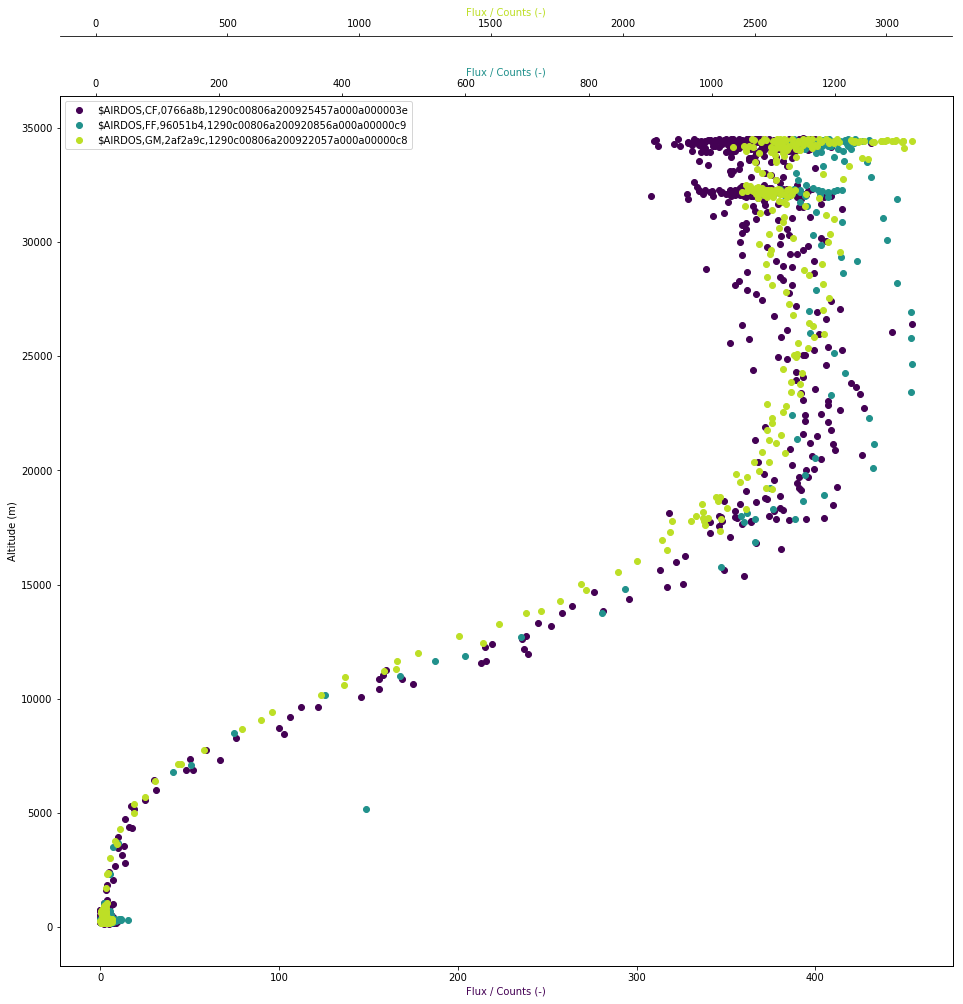

In [5]:
temp2gain = lambda T: 8.721e5-1.407e4*T

nav_merged = pd.concat([log.nav for log in gm_logs])

def alt_for(m):
    alt = nav_merged['Alt']
    return alt.reindex(alt.index.union(m.index)).interpolate(method='index', limit=5).reindex(m.index)


def cf_flux(candy):
    spec = np.array(list(map(list, candy['Bins'])))
    flux = pd.Series(np.sum(spec[:,50:200], axis=1), index=candy.index)
    return flux / temp2gain(10) * temp2gain(10)

def sum_every_n(s, N):
    assert isinstance(s, pd.Series)
    a = np.array(s.array)
    a = np.sum(a[:len(a)//N*N].reshape((-1, N)), axis=1)
     
    return pd.Series(data=a, index=s.index.array[N//2:len(a)*N:N])

detector_intensities = [
    (logs[0].greeting, pd.concat([flux_acc(d) for d in logs]))
    for logs, flux_acc in zip((cf_logs, ff_logs, gm_logs),
        (lambda m: sum_every_n(cf_flux(m.candy), 10),
         lambda m: sum_every_n(m.candy['Flux'], 30),
         lambda m: sum_every_n(m.gm['GMCount'], 30)))
]

import matplotlib.pyplot as plt 

fig = plt.figure(figsize=(16, 16))
host = fig.add_subplot(111)

par1 = host.twiny()
par2 = host.twiny()

host.set_ylabel("Altitude (m)")

lns = []
for _I, axes, color in zip(detector_intensities, [host, par1, par2], [plt.cm.viridis(0), plt.cm.viridis(0.5), plt.cm.viridis(.9)]):
    label, I = _I
    
    axes.set_xlabel("Flux / Counts (-)", color=color)
    p = axes.scatter(I, alt_for(I), color=color, label=label)
    lns.append(p)

host.legend(handles=lns, loc='best')
par2.spines['top'].set_position(('outward', 60))      


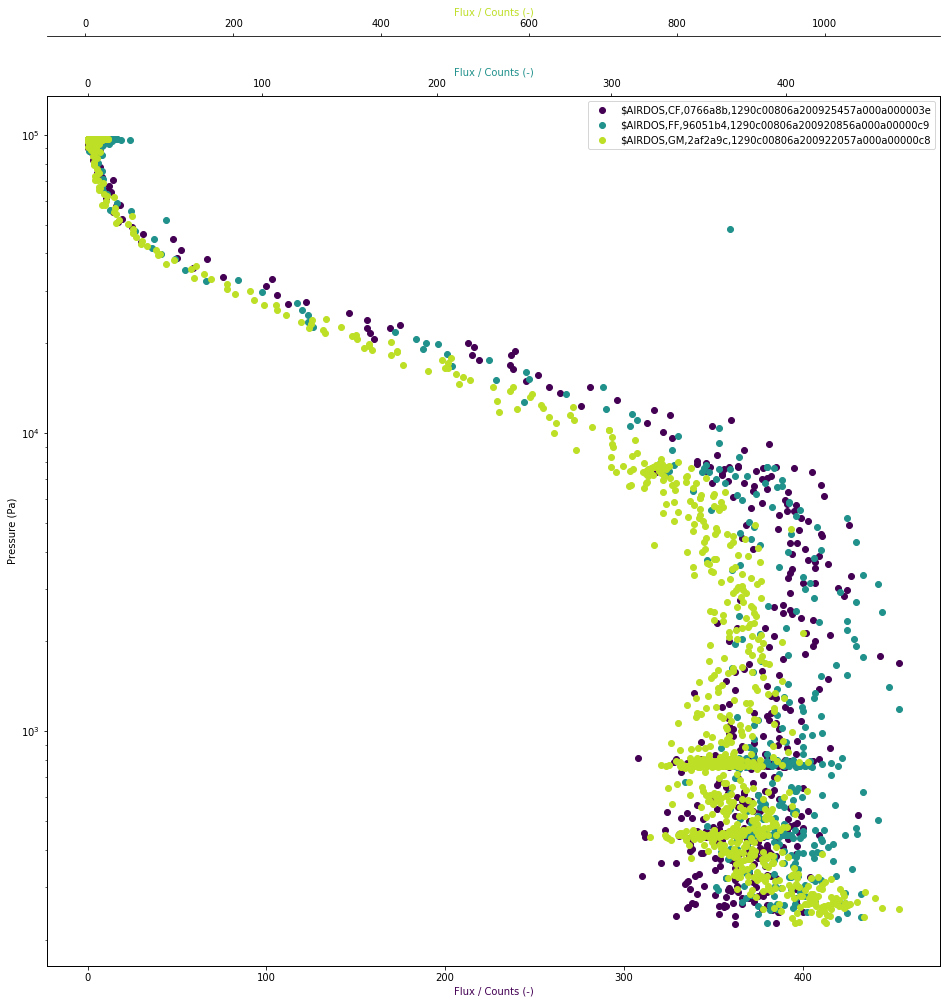

In [6]:
cf_merged = pd.concat([log.candy for log in cf_logs])

def pressure_for(m):
    alt = cf_merged['Pressure']
    return alt.reindex(alt.index.union(m.index)).interpolate(method='index', limit=5).reindex(m.index)


def sum_every_n(s, N):
    assert isinstance(s, pd.Series)
    a = np.array(s.array)
    a = np.sum(a[:len(a)//N*N].reshape((-1, N)), axis=1)
     
    return pd.Series(data=a, index=s.index.array[N//2:len(a)*N:N])

detector_intensities = [
    (logs[0].greeting, pd.concat([flux_acc(d) for d in logs]))
    for logs, flux_acc in zip((cf_logs, ff_logs, gm_logs),
        (lambda m: sum_every_n(cf_flux(m.candy), 10),
         lambda m: sum_every_n(m.candy['Flux'], 10),
         lambda m: sum_every_n(m.gm['GMCount'], 10)))
]

import matplotlib.pyplot as plt 

fig = plt.figure(figsize=(16, 16))
host = fig.add_subplot(111)

par1 = host.twiny()
par2 = host.twiny()

host.set_yscale("log")
host.set_ylabel("Pressure (Pa)")

lns = []
for _I, axes, color in zip(detector_intensities, [host, par1, par2], [plt.cm.viridis(0), plt.cm.viridis(0.5), plt.cm.viridis(.9)]):
    label, I = _I
    
    axes.set_xlabel("Flux / Counts (-)", color=color)
    p = axes.scatter(I, pressure_for(I), color=color, label=label)
    lns.append(p)

host.legend(handles=lns, loc='best')
par2.spines['top'].set_position(('outward', 60))      

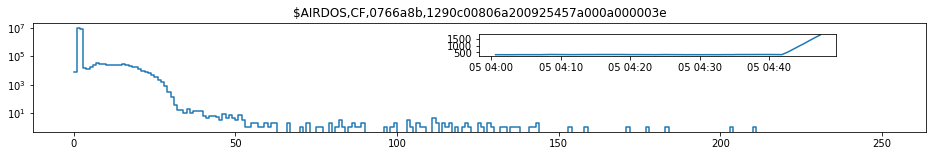

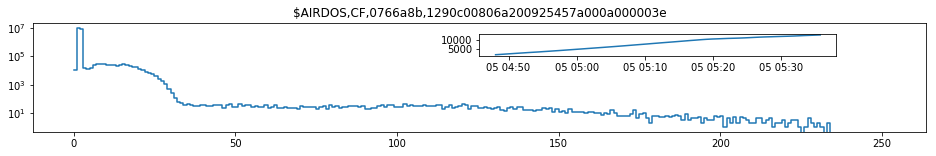

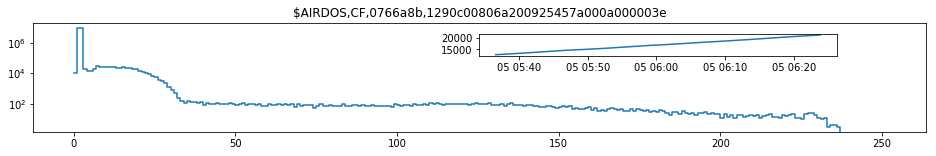

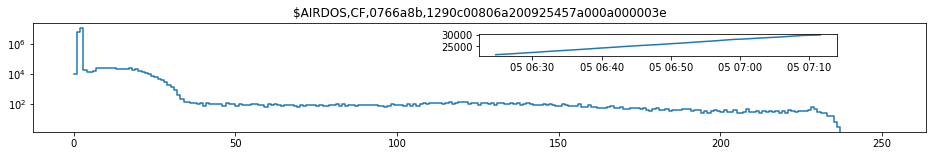

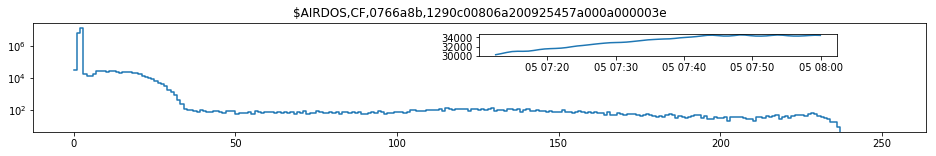

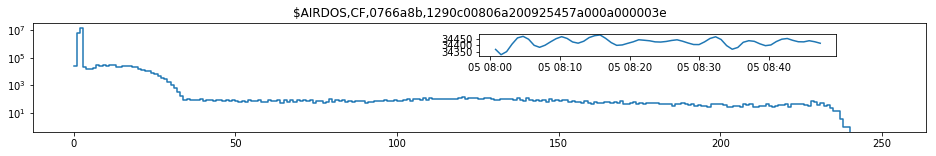

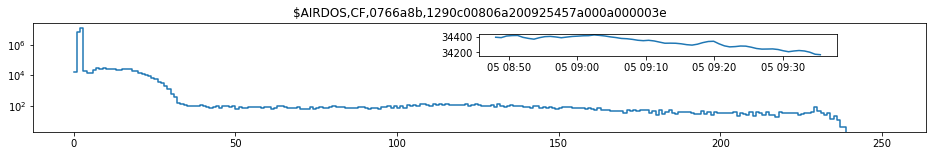

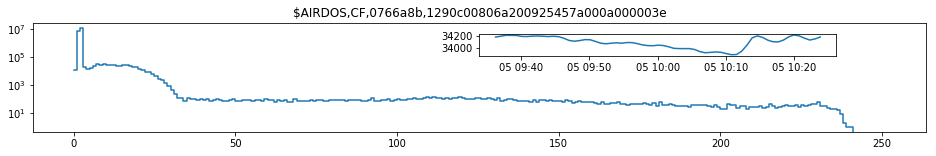

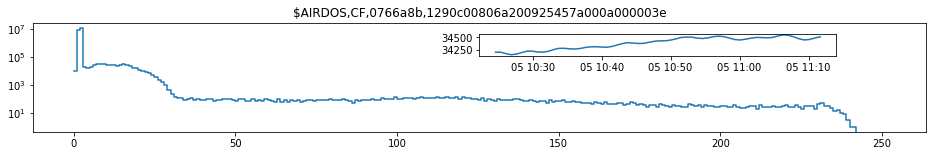

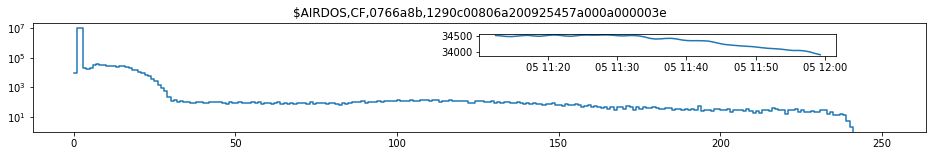

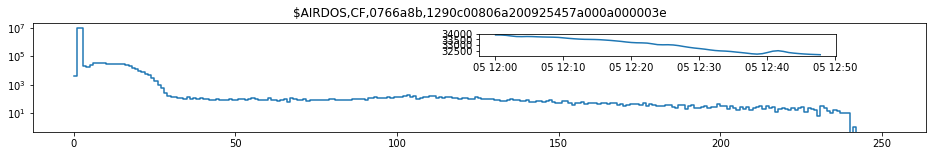

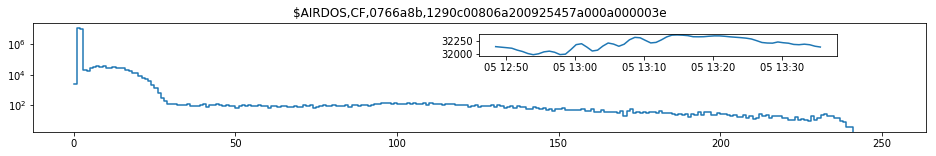

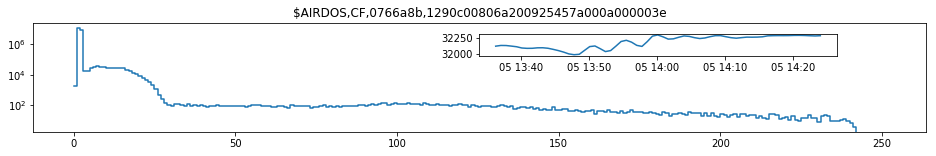

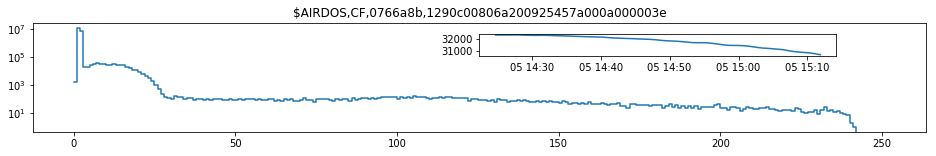

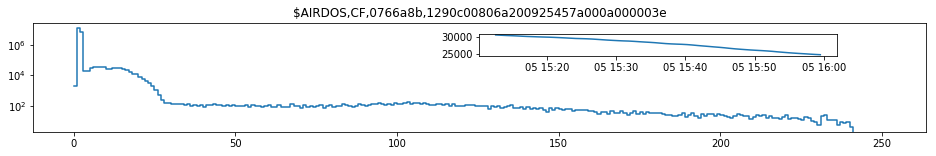

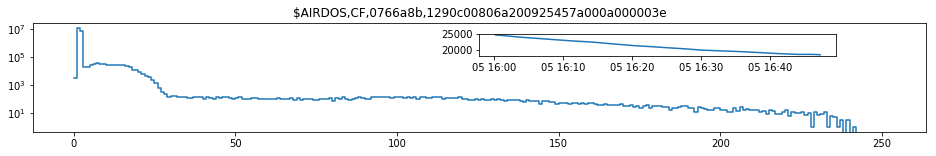

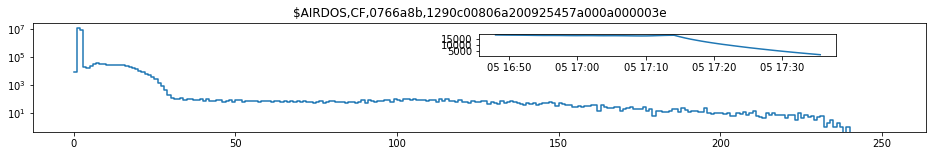

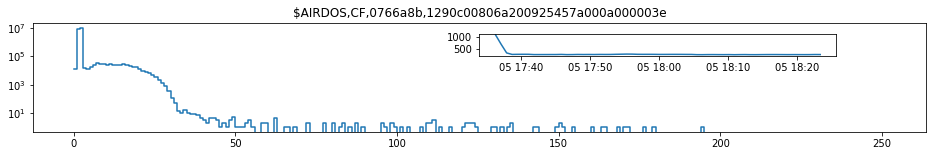

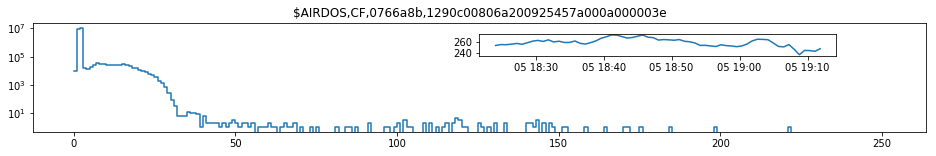

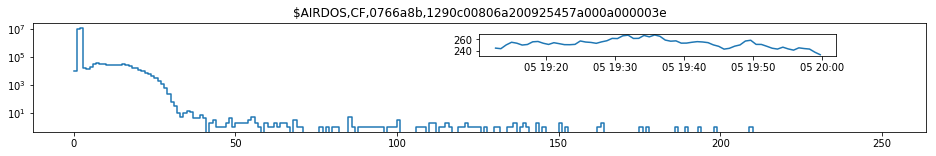

In [28]:
def plot_spectra_in_time_mod(tfrom, tto):
    if isinstance(tto, pd.Timedelta):
        tto = tfrom + tto
    
    fig, axes = plt.subplots(figsize=(16, 2), nrows=1)
    
    axes = [axes]
    
    for ax in axes: #.flat:
        nav_merged = pd.concat([log.nav for log in cf_logs])
        n = nav_merged[np.logical_and(nav_merged.index > tfrom, nav_merged.index < tto)]
        ax.inset_axes([0.5, 0.7, 0.4, 0.2]).plot(n.index, n['Alt'])
    
    for logs, axes in zip([cf_logs, ff_logs], axes):
        candy_merged = pd.concat([log.candy for log in logs])
        c = candy_merged[np.logical_and(candy_merged.index > tfrom, candy_merged.index < tto)]
        spec = np.array(list(map(list, c['Bins'])))
        axes.set_title(logs[0].greeting)
        axes.set_yscale('log')
        axes.plot(np.sum(spec, axis=0), drawstyle='steps-post')
        #axes.set_xlim(0, 50)
        #axes.set_ylim(4e3, 4e4)

N = 20

s = pd.Timestamp(year=2019, month=9, day=5, hour=4, tz='UTC') #cf_logs[0].candy.index[0]
e = pd.Timestamp(year=2019, month=9, day=5, hour=20, minute=0, tz='UTC') #cf_logs[0].candy.index[-1]

delta = e - s
m = delta/N

for i in range(N):
    plot_spectra_in_time_mod(s+m*i, s+m*(i+1))

In [7]:
ax.plot(m.index, )
ax2 = ax.twinx()
ax2.set_ylim(0, 3000)
ax2.plot(cf_logs[0].candy.index, cf_logs[0].candy['Pressure'], color='orange')

m = cf_logs[0].candy['Flux']
fig, ax = plt.subplots(figsize=(16, 5), nrows=1)
ax.plot(m.index, m)
ax2 = ax.twinx()
ax2.plot(cf_logs[0].candy.index, cf_logs[0].candy['Temp'], color='orange')

NameError: name 'ax' is not defined

In [8]:
cf_merged = pd.concat([log.candy for log in cf_logs])

def pressure_for(m):
    alt = cf_merged['Pressure']
    return alt.reindex(alt.index.union(m.index)).interpolate(method='index', limit=5).reindex(m.index)

def sum_every_n(s, N):
    assert isinstance(s, pd.Series)
    a = np.array(s.array)
    a = np.sum(a[:len(a)//N*N].reshape((-1, N)), axis=1)
     
    return pd.Series(data=a, index=s.index.array[N//2:len(a)*N:N])

def cf_flux(candy):
    spec = np.array(list(map(list, candy['Bins'])))
    flux = pd.Series(np.sum(spec[:,50:200], axis=1), index=candy.index)
    return flux / temp2gain(10) * temp2gain(10)

intensities = [
    (logs[0].greeting, pd.concat([flux_acc(d) for d in logs]))
    for logs, flux_acc in zip((cf_logs, ff_logs, gm_logs),
        (lambda m: cf_flux(m.candy),
         lambda m: m.candy['Flux'],
         lambda m: m.gm['GMCount']))
]

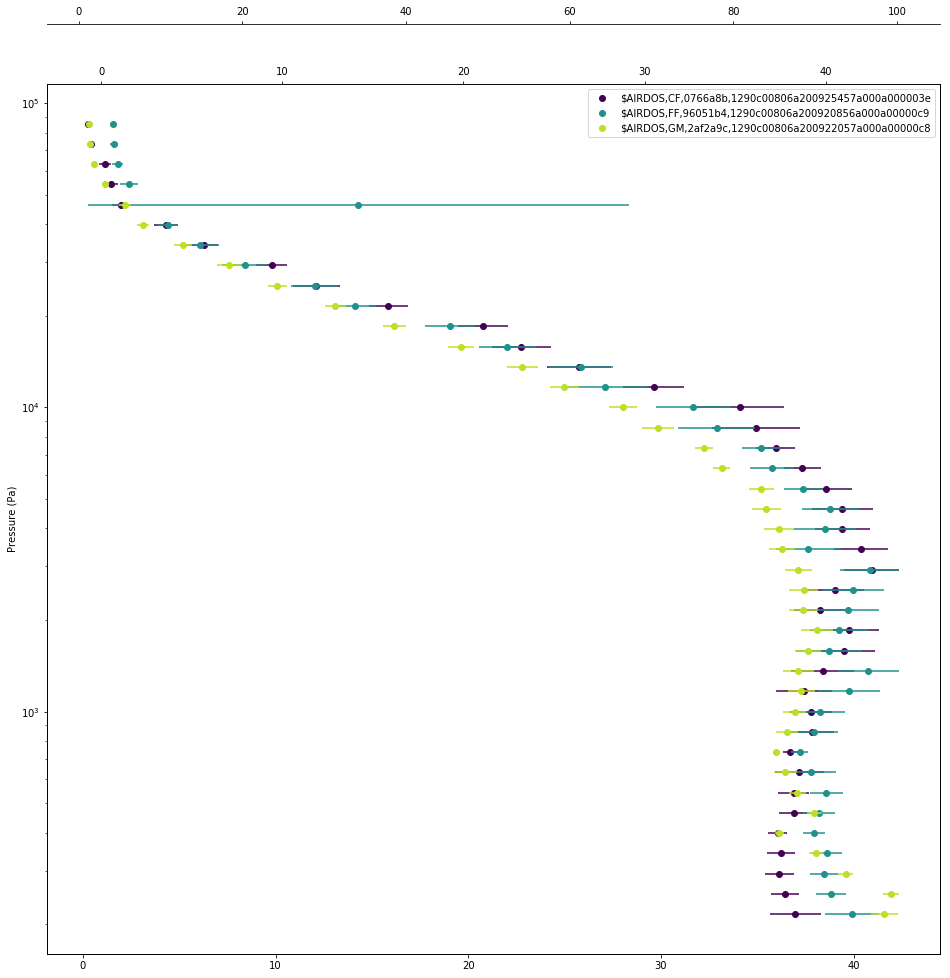

In [9]:
fig = plt.figure(figsize=(16, 16))
host = fig.add_subplot(111)

par1 = host.twiny()
par2 = host.twiny()

host.set_ylabel('Pressure (Pa)')
host.set_yscale('log')

for I_, ax, col in zip(intensities, [host, par1, par2], [plt.cm.viridis(0), plt.cm.viridis(0.5), plt.cm.viridis(.9)]):
    greet, I = I_
    m = pd.DataFrame({'I': I, 'P': pressure_for(I)}).dropna()
    k = (pd.Series(data=m['I'].values, index=m['P'].values).dropna().groupby(lambda x: 10**(int(np.log10(x)*15)/15)))
    mean = k.mean()
    index = mean.index
    stderr = k.sem()
    ax.errorbar(mean.values, index, color=col, label=greet, xerr=2*stderr, fmt='o')

host.legend(handles=lns, loc='best')
par2.spines['top'].set_position(('outward', 60))  

In [ ]:
fig = plt.figure(figsize=(16, 16))
host = fig.add_subplot(111)

par1 = host.twiny()
par2 = host.twiny()

host.set_ylabel('Pressure (Pa)')
host.set_yscale('log')

for I_, ax, col in zip(intensities, [host, par1, par2], [plt.cm.viridis(0), plt.cm.viridis(0.5), plt.cm.viridis(.9)]):
    greet, I = I_
    m = pd.DataFrame({'I': I, 'P': pressure_for(I)}).dropna()
    k = (pd.Series(data=m['I'].values, index=m['P'].values).dropna().groupby(lambda x: 10**(int(np.log10(x)*15)/15)))
    mean = k.mean()
    index = mean.index
    stderr = k.sem()
    ax.errorbar(mean.values, index, color=col, label=greet, xerr=2*stderr, fmt='o')

host.legend(handles=lns, loc='best')
par2.spines['top'].set_position(('outward', 60))  

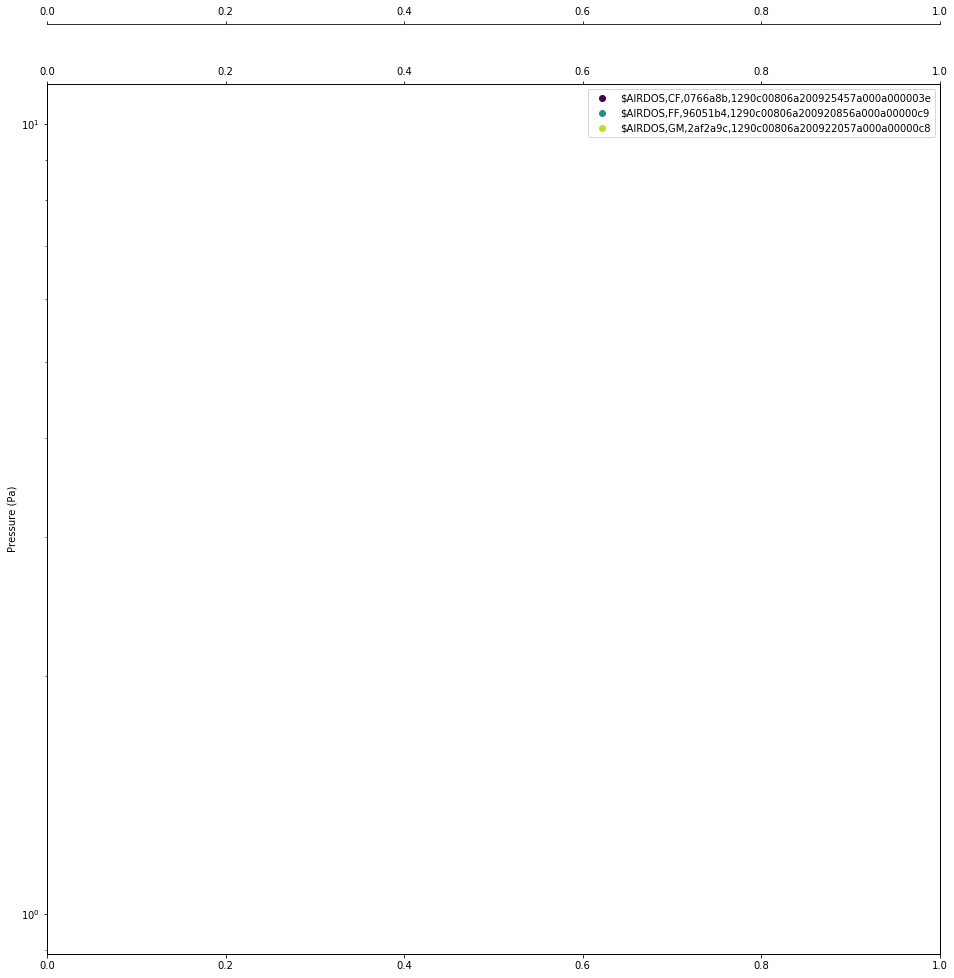

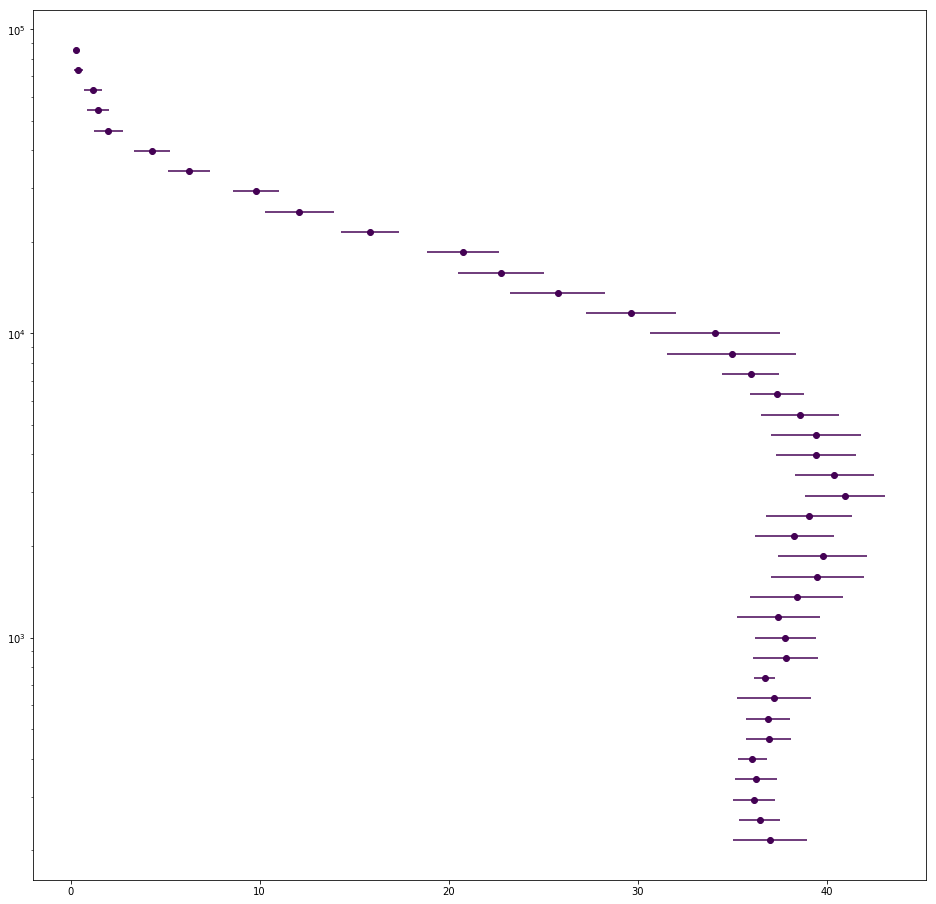

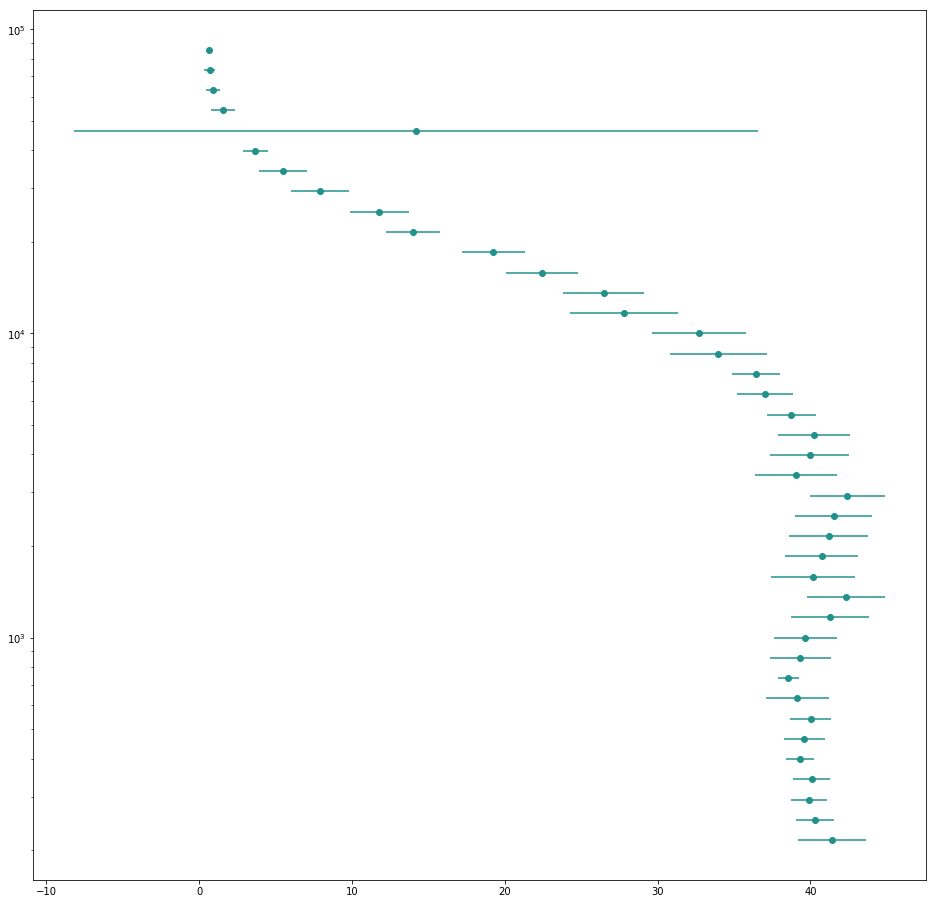

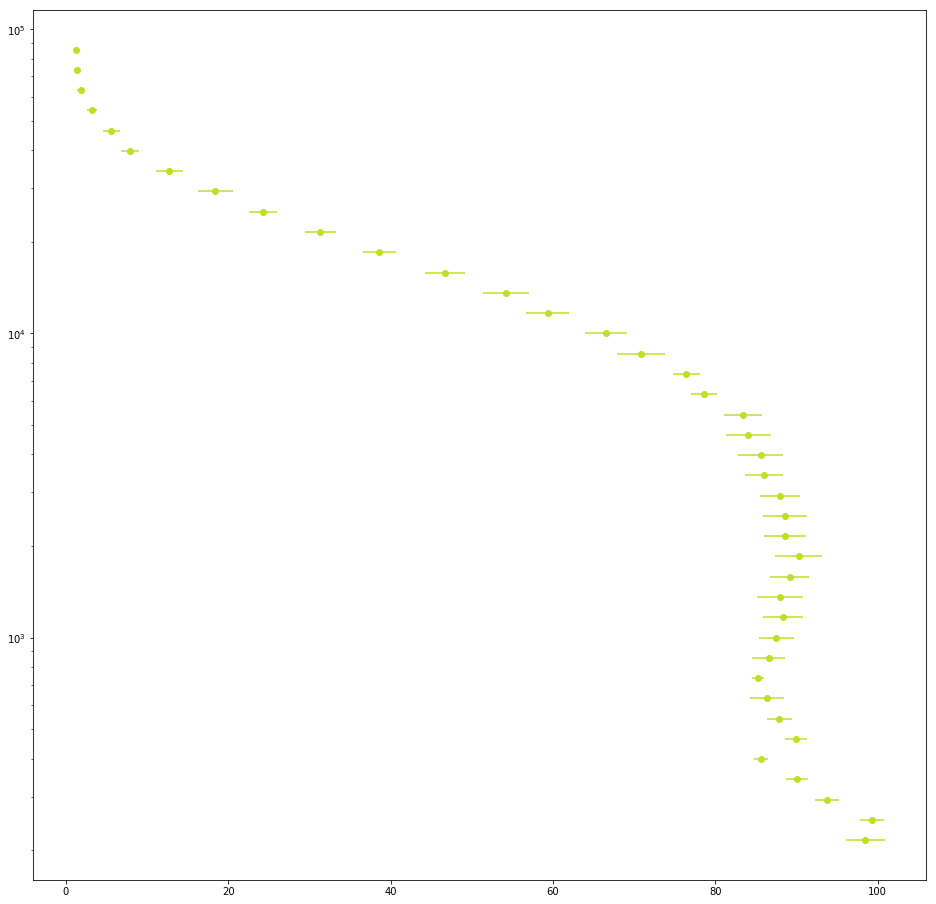

In [25]:
fig = plt.figure(figsize=(16, 16))
host = fig.add_subplot(111)

par1 = host.twiny()
par2 = host.twiny()

host.set_ylabel('Pressure (Pa)')
host.set_yscale('log')

for I_, ax, col in zip(intensities, [host, par1, par2], [plt.cm.viridis(0), plt.cm.viridis(0.5), plt.cm.viridis(.9)]):
    fig = plt.figure(figsize=(16, 16))
    greet, I = I_
    m = pd.DataFrame({'I': I, 'P': pressure_for(I)}).dropna()
    k = (pd.Series(data=m['I'].values, index=m['P'].values).dropna().groupby(lambda x: 10**(int(np.log10(x)*15)/15)))
    mean = k.mean()
    index = mean.index
    stderr = k.sem()
    #stderr = k.var()/100
    plt.errorbar(mean.values, index, color=col, label=greet, xerr=3*stderr, fmt='o')
    plt.yscale('log')

host.legend(handles=lns, loc='best')
par2.spines['top'].set_position(('outward', 60))  